In [75]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import pydicom
import nibabel as nib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, clear_output

import os
import os.path
import scipy as sp
import scipy.ndimage

from fcmeans import FCM

from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans

from skimage import segmentation, measure

In [76]:
def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    return axs

def load_dcm_volume(directory):
    """
    Funzione che carica un volume di dati DICOM da una cartella
    assumendo che questa contenga solamente un insieme di file .dcm
    """

    # leggiamo la lista dei file nella cartella
    files = os.listdir(directory)
    files.sort()
    
    # leggiamo il primo file per ottenere le dimensioni e il tipo della singola slice
    file = pydicom.dcmread(f'{directory}/{files[0]}')
    
    # creiamo il volume
    volume = np.full((len(files),file.pixel_array.shape[0],file.pixel_array.shape[1]),\
                    1,dtype=file.pixel_array.dtype)

    # carichiamo la prima slice, già letta, e successivamente le altre 
    volume[0,:,:] = file.pixel_array

    for i in range(1,len(files)):
        volume[i,:,:] = pydicom.dcmread(f'{directory}/{files[i]}').pixel_array
    
    vol = np.copy(volume)

    if file.SeriesDescription != '' and file.SeriesDescription.find('Sag') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[2],volume.shape[0]))

        for i in range(volume[:,0,:].shape[1]):
            vol[i,:,:] = volume[:,i,:].T
    
    if file.SeriesDescription != '' and file.SeriesDescription.find('Cor') != -1:
        vol=np.reshape(vol,(volume.shape[1],volume.shape[0],volume.shape[2]))

        for i in range(volume[:,0,:].shape[0]):
            vol[i,:,:] = volume[:,i,:]
    
    return vol


In [77]:
def collect_values(row, threshold=0.7):

    # Calcoliamo il gradiente del segnale row
    # e individuiamo i picchi superiori a threshlod del massimo
    # o inferiori a -threshold del minimo
    gg = np.gradient(row)
    peaks = scipy.signal.find_peaks(gg,height=threshold*np.max(gg))
    igg = gg * -1
    invpeaks = scipy.signal.find_peaks(igg,height=threshold*np.max(igg))

    # Tenendo conto della forma del nostro segnale che è sempre positivo o nullo
    # scandiamo gli array degli indici dei picchi copiando in uscita i valori che 
    # si trovano all'interno degli intervalli di tipo [picco positivo - picco negativo]
    out = np.zeros(row.shape)
    j = 0
    start = 0
    stop = 0
    
    if len(peaks[0]) > 0 and len(invpeaks[0]) > 0:
        for i in range(len(peaks[0])):

            start = peaks[0][i]
            if start <= stop:
                continue
            
            while j < len(invpeaks[0]) - 1 and invpeaks[0][j] <= start:
                j = j+1
            stop = invpeaks[0][j]

            out[start:stop+1] = row[start:stop+1]
    else:
        out = row
        
    return out

def projection(volume, mode='mip', direction='coronal', threshold=None, alpha=None):

    if mode == 'composite':

        if np.array(alpha).shape == ():
            raise(ValueError('alpha must be an array of values in [0, 1] with the same shape as volume'))
        if alpha.shape != volume.shape:
            raise(ValueError('alpha must have the same shape volume'))
        if np.max(alpha) > 1.0 or np.min(alpha) < 0.0:
            raise(ValueError('All alpha values must range in [0, 1]'))

    if threshold == None:
        t = 0.7
    else:
        t = threshold

    axis = 1 if direction == 'coronal' else 0 if direction == 'axial' else 2

    shape = (volume.shape[0] if axis != 0 else volume.shape[1],\
            volume.shape[1] if axis ==2 else volume.shape[2])
    
    proj = np.zeros(shape=shape,dtype='float')

    if mode == 'mip':
        proj = np.max(volume,axis=axis)
    else:

        if t == 0:
            
            if mode == 'minip':

                proj = np.min(volume, axis=axis)
            
            if mode == 'avg':

                proj = np.average(volume,axis=axis)
            
            if mode == 'composite':

                for i in range(shape[0]):
                    for j in range(shape[1]):
                        
                        row = volume[i,:,j] if axis ==1\
                            else volume[i,j,:] if axis == 2 else volume[:,i,j]

                        c = 0

                        for k in np.arange(alpha.shape[axis]-1,-1,-1):
                            
                            a = alpha[i, j, k] if axis == 2 else alpha[k, i, j]\
                                    if axis == 0 else alpha[i, k, j]
                            c = ((1 - a)*c + a*row[k])
                            
                        proj[i, j] = c

        else:

            for i in range(shape[0]):
                for j in range(shape[1]):
                    
                    row = collect_values(volume[i,:,j] if axis ==1\
                        else volume[i,j,:] if axis == 2 else volume[:,i,j], threshold = t)
                    
                    if mode == 'minip':

                        if len(row[row > 0]) > 0:
                            proj[i,j] = np.min(row[row > 0])
                        else:
                            proj[i,j] = 0

                                
                    if mode == 'avg':

                        if len(row[row > 0]) > 0:
                            proj[i,j] = np.average(row[row > 0])
                        else:
                            proj[i,j] = 0

                    
                    if mode == 'composite':

                        if len(row[row > 0]) == 0:
                            proj[i, j] = 0
                        else:
                            c = 0.0

                            for k in np.arange(alpha.shape[axis]-1,-1,-1):
                                a = alpha[i, j, k] if axis == 2 else  alpha[k, i, j]\
                                    if axis == 0 else alpha[i, k, j]
                                c = ((1 - a)*c + a*row[k])
                            
                            proj[i, j] = c
    
    return proj
    

In [78]:
brain = load_dcm_volume('Data/Sag_FLAIR+FATSAT_CUBE_3')

brain[brain <= 40] = 0

flat_brain = brain.reshape((brain.shape[0]*brain.shape[1]*brain.shape[2],1))


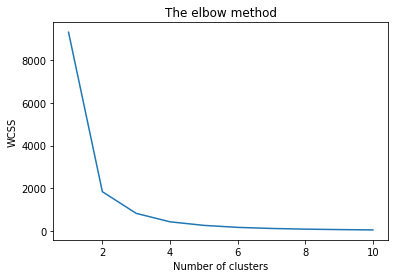

In [79]:
sample_brain = brain[:,:,65:71].astype('float32')

sample_brain = sample_brain / sample_brain.max()

sample_flat_brain = sample_brain.reshape((sample_brain.shape[0]*sample_brain.shape[1]*sample_brain.shape[2],1))

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(sample_flat_brain)
    wcss.append(kmeans.inertia_)
    
#facciamo il plot
plt.gca().plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()





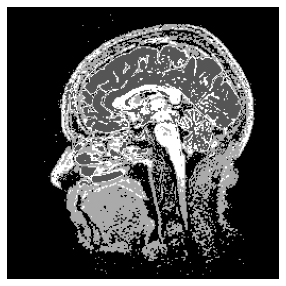

In [63]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
labels = kmeans.fit_predict(flat_brain/flat_brain.max())

clustered = labels.reshape(brain.shape)

axes = plot_images([clustered[:,:,68]])

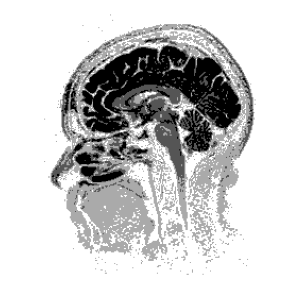

In [80]:
num_clusters = 4

fcm_brain = FCM(n_clusters=num_clusters)
fcm_brain.fit(flat_brain)
fcm_brain_labels = fcm_brain.predict(flat_brain)

brain_clustered = fcm_brain_labels.reshape(brain.shape)
axes = plot_images([brain_clustered[:,:,68]])

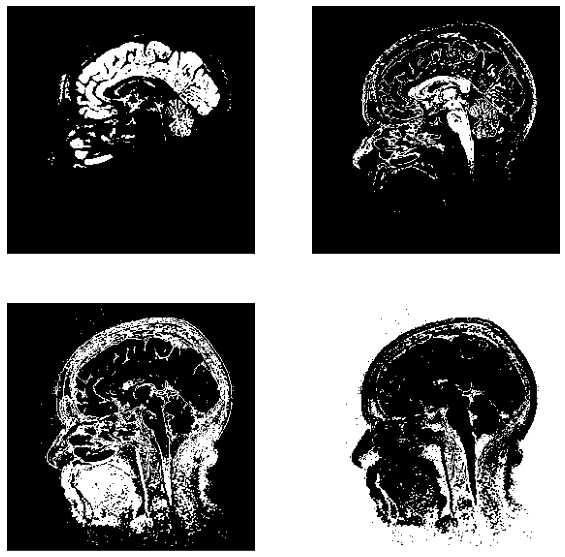

In [81]:
clusters = np.full((num_clusters,brain.shape[0],brain.shape[1],brain.shape[2]),0)

for i in range(num_clusters):
    clusters[i] = np.where(brain_clustered == i, 1, 0)

axes = plot_images(clusters[:,:,:,68])

In [148]:
alpha = segmentation.flood(clusters[3],(128,150,68))

#alpha = np.where(clusters[3] == 1, 0.0, 1.0)

p = projection(brain,direction='sagittal',mode='composite',threshold=0, alpha=alpha)


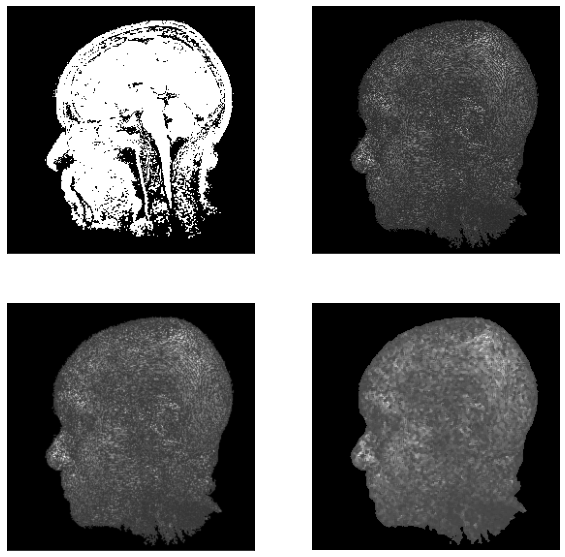

In [149]:
axes = plot_images([alpha[:,:,68],p,scipy.ndimage.gaussian_filter(p,sigma=0.5),\
    scipy.ndimage.median_filter(p,size=3)])

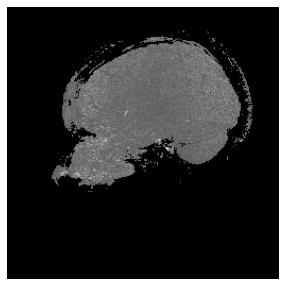

In [127]:
p = projection(brain,direction='sagittal',mode='composite',threshold=0, alpha=clusters[0])

axes = plot_images([p])


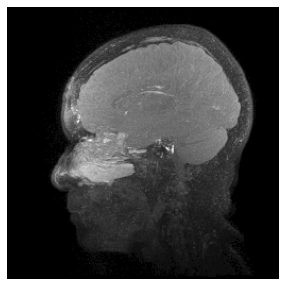

In [82]:
p = projection(brain,direction='sagittal',mode='mip')
axes = plot_images([p])

In [86]:
minc = nib.load('Data/phantom_1.0mm_normal_fuzzy/phantom_1.0mm_normal_skn.mnc.gz')

data = nib.load('Data/phantom_1.0mm_normal_fuzzy/phantom_1.0mm_normal_crisp.mnc.gz')

brainweb = minc.get_fdata()
data_crisp = data.get_fdata()

alpha = np.where(brainweb >1 , 1, brainweb)


In [87]:
proj = projection(brainweb,direction='sagittal',mode='composite',alpha=alpha,threshold=0)

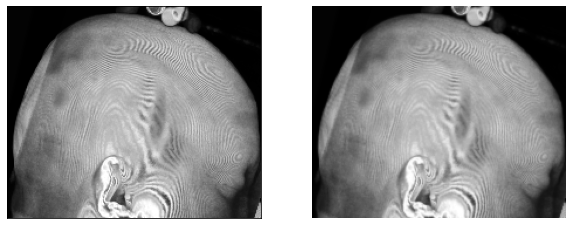

In [88]:
axes = plot_images([proj,scipy.ndimage.gaussian_filter(proj,sigma=0.5)],origin='lower')